In [34]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, SpatialDropout1D, Dropout, BatchNormalization, Bidirectional, GlobalMaxPool1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from keras.initializers import Constant
from nltk.tokenize import word_tokenize

In [33]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 

In [5]:
tweets_train.head(10)

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [36]:
#Eliminamos los emojis del texto
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF" 
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

#Almacenamos el texto limpio en una nueva feature del dataframe
tweets_train['cleaned_text']=tweets_train['text'].apply(lambda x: remove_emoji(x))
tweets_test['cleaned_text']=tweets_test['text'].apply(lambda x: remove_emoji(x))

In [37]:
#Eliminamos los numeros, url, simbolos y signos de puntuacion del texto 
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [38]:
tweets_train['cleaned_text'] = tweets_train['cleaned_text'].apply(lambda x: clean_text(x))
tweets_test['cleaned_text'] = tweets_test['cleaned_text'].apply(lambda x: clean_text(x))

In [39]:
train_text_emb = tweets_train.cleaned_text
test_emb = tweets_test.cleaned_text
train_target_emb = tweets_train.target

In [42]:
#Tokenizer 
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_text_emb)
vocab_length = len(word_tokenizer.word_index) + 1

In [43]:
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [44]:
longest_train = max(train_text_emb, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train_text_emb), length_long_sentence, padding='post')
test_sentences = pad_sequences(embed(test_emb), length_long_sentence, padding='post')

In [45]:
y = np.asarray(train_target_emb)

In [46]:
#Separamos al dataset tweets_train en un set de entrenamiento y uno de validacion, para text y para target
#El tamaño del set de validacion es del 25% del original
xTrain, xVal, yTrain, yVal = train_test_split(padded_sentences, y, test_size=0.25)

In [47]:
#GloVe
#Creacion de diccionario de palabras a partir del archivo preentrenado de GloVe
embeddings_dictionary = dict()
embedding_dim = 50
glove_file = open('Dataset/glove.6B.50d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [48]:
#Creacion de matriz de ocurrencias de palabras que se encuentran en los textos de los tweets
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [49]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [50]:
model = BLSTM()
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor = 'val_loss', 
    verbose = 1, 
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = 0.2, 
    verbose = 1, 
    patience = 5,                        
    min_lr = 0.001
)
history = model.fit(xTrain,yTrain,epochs=10,batch_size=32, validation_data=(xVal, yVal), verbose = 1, callbacks = [checkpoint, reduce_lr])

Epoch 1/10
178/179 [============================>.] - ETA: 0s - loss: 0.7676 - accuracy: 0.6081
Epoch 00001: val_loss improved from inf to 0.63296, saving model to model.h5
179/179 [==============================] - 7s 38ms/step - loss: 0.7672 - accuracy: 0.6080 - val_loss: 0.6330 - val_accuracy: 0.7169
Epoch 2/10
178/179 [============================>.] - ETA: 0s - loss: 0.5918 - accuracy: 0.7065
Epoch 00002: val_loss improved from 0.63296 to 0.51285, saving model to model.h5
179/179 [==============================] - 6s 35ms/step - loss: 0.5914 - accuracy: 0.7068 - val_loss: 0.5128 - val_accuracy: 0.7878
Epoch 3/10
178/179 [============================>.] - ETA: 0s - loss: 0.5047 - accuracy: 0.7763
Epoch 00003: val_loss improved from 0.51285 to 0.43931, saving model to model.h5
179/179 [==============================] - 6s 36ms/step - loss: 0.5043 - accuracy: 0.7763 - val_loss: 0.4393 - val_accuracy: 0.8009
Epoch 4/10
179/179 [==============================] - ETA: 0s - loss: 0.4800 

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 31, 50)            841700    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 31, 62)            20336     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 62)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62)                248       
_________________________________________________________________
dropout_3 (Dropout)          (None, 62)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 31)                1953      
_________________________________________________________________
dropout_4 (Dropout)          (None, 31)               

In [52]:
def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('Epoch ',fontsize=16)
        ax[idx].set_ylabel('Value',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

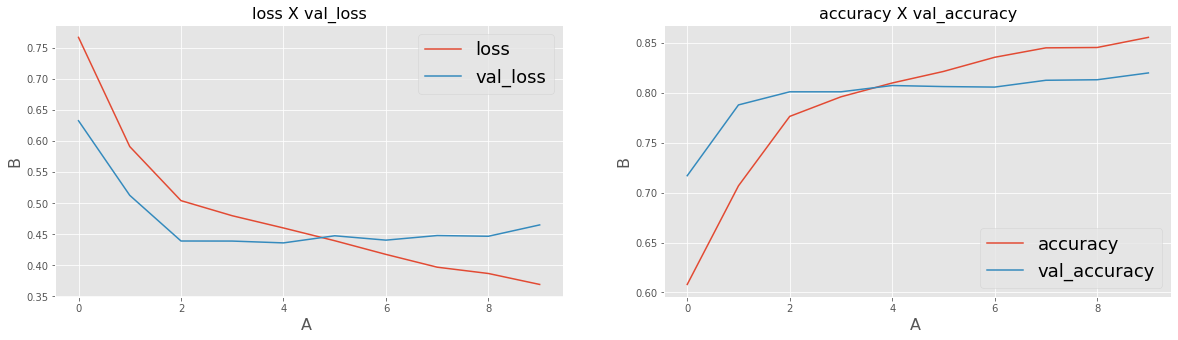

In [53]:


plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])



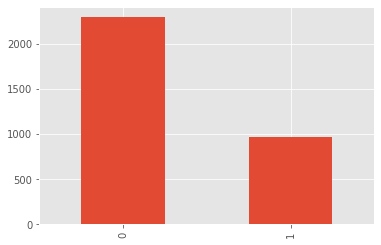

In [30]:
tweets_submission.target = model.predict_classes(test_sentences)
tweets_submission.to_csv("submission.csv", index=False)
tweets_submission.target.value_counts().plot.bar();